In [4]:
# Import things
%matplotlib inline
import matplotlib
#matplotlib.use('Agg')

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as md
import pandas as pd
from matplotlib import rcParams
import os
import glob
from scipy import io

# Supress warnings for sake of log file
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Set up plots
# Plotting preferences

rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 14}) 
rcParams['axes.titlepad'] = 14 
rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'
myFmt = md.DateFormatter('%H')
rule = md.HourLocator(interval=1)

In [84]:
# To be moved when function made
d_loc='/Users/heather/Desktop/aerosol_quicklooks/'
d2 = dt.datetime.utcnow()
d2 = d2.replace(minute=0, second=0, microsecond=0)
d1 = d2 - dt.timedelta(hours=24)

d1 = dt.datetime(2019,7,18,0,0)
d2 = dt.datetime(2019,7,19,0,0)

today = dt.datetime.utcnow()
yesterday = today - dt.timedelta(hours=24)

In [78]:
def get_opc(opc_n,d_loc,d1,d2):
    os.chdir(d_loc+'Data/')                  # Change directory to where the data is
    #log = open(log_licor,'w')             # Open the log file for writing
    all_files = glob.glob('*%s*OPC*'%opc_n)
    if opc_n=='TAWO':
        file_dates = np.asarray([(dt.datetime.strptime(f[-12:-4], '%Y%m%d')).date() for f in all_files])
    else:
        file_dates = np.asarray([(dt.datetime.strptime(f[-14:-4], '%Y-%m-%d')).date() for f in all_files])
           
    idxs = np.where(np.logical_and(file_dates>=d1.date(), file_dates<=d2.date()))[0]
    dfs = [all_files[i] for i in idxs]
    opc = pd.DataFrame()
    # Extract the data
    for f in dfs: 
        # Ignore file if it's empty
        if os.path.getsize(f)==0:
            #log.write('Error with: '+f+' this file is empty.\n')
            continue 
        opc = opc.append(pd.read_csv(f, skiprows=4,sep=',',error_bad_lines=False))  
    opc['Dates'] = pd.to_datetime(opc['time'],format='%Y-%m-%d %H:%M:%S')
    opc = opc.sort_values('Dates')
    opc = opc.set_index(opc['Dates'])
    opc.index = pd.DatetimeIndex(opc.index)
    #opc = opc[~opc.index.duplicated()]
    del opc['time'], opc['Dates']

    # Convert flow rate from L/min to cm3/s
    # 1 L/min = 16.66667 cm3/s
    opc.FlowRate = opc.FlowRate/100 * 16.66667

    # Get total counts
    opc['total_counts']=opc['b0'].astype(float)+ opc['b1'].astype(float)+ opc['b2'].astype(float)+ opc['b3'].astype(float)+ opc['b4'].astype(float)+ opc['b5'].astype(float)+ opc['b6'].astype(float)+ opc['b7'].astype(float)+ opc['b8'].astype(float)+ opc['b9'].astype(float)+ opc['b10'].astype(float)+ opc['b11'].astype(float)+ opc['b12'].astype(float)+ opc['b13'].astype(float)+ opc['b14'].astype(float)+ opc['b15'].astype(float)+ opc['b16'].astype(float)+ opc['b17'].astype(float)+ opc['b18'].astype(float)+ opc['b19'].astype(float)+ opc['b20'].astype(float)+ opc['b21'].astype(float)+ opc['b22'].astype(float)+ opc['b23'].astype(float)
    opc['total_counts']=opc['total_counts'].replace({0: np.nan})
    # Convert total counts/interval to total counts/s
    opc.period = opc.period/100 # period in s
    opc.total_counts = opc.total_counts /opc.period
    # Convert total counts/second to counts/cm3
    opc['OPC_conc'] = opc.total_counts / opc.FlowRate

    return opc

In [82]:
# Function to read SKYOPC data
# Get SKYOPC Data
# Measurement interval 6 seconds
# I think C0 = time
# C1 = time + 6 s
# C2 = time + 12 s
# ect.

# 32 channels 
# data output in the unit particle/100ml

# SKYOPC chaneel boundaries:
#0.25,0.28,0.3,0.35,0.4,0.45,0.5,0.58,0.65,0.7,0.8,1.0,1.3,1.6,2,2.5,3,3.5,4,5,6.5,7.5,8.5,10,12.5,15,17.5,20,25,30,32 
#channels 16 and 17 are identical (overlapping 
#channel for different physical measurement ranges)...so one should be 
#discarded before analysis.

# Function to read and import GRIMM OPC data
def get_skyopc(d_loc,d1,d2):
    os.chdir(d_loc+'Data/')                  # Change directory to where the data is
    #log = open(log_licor,'w')             # Open the log file for writing
    all_files = glob.glob('*SKYOPC*')
    file_dates = np.asarray([(dt.datetime.strptime(f[-14:-4], '%Y-%m-%d')).date() for f in all_files])
    idxs = np.where(np.logical_and(file_dates>=d1.date(), file_dates<=d2.date()))[0]
    dfs = [all_files[i] for i in idxs]
    skyopc = pd.DataFrame()
    # Extract the data
    for f in dfs: 
        # Ignore file if it's empty
        if os.path.getsize(f)==0:
            #log.write('Error with: '+f+' this file is empty.\n')
            continue 
        f_data = open(f)
        d = f_data.readlines()
        f_data.close()
        for i in range(0,len(d)):
            line=d[i].split()
            if len(line)<8:
                continue
            if line[0] =='P':
                #Year Mon Day Hr Min Loc 4Tmp Err pA/p pR/p UeL Ue4 Ue3 Ue2 Ue1 Iv 
                datetime = dt.datetime(int(line[1])+2000,int(line[2]),int(line[3]),int(line[4]),int(line[5]))
                #datetime = dt.datetime.strptime('20'+line[1]+line[2]+line[3]+line[4]+line[5],'%Y%m%d%H%M')
                quad_Tmp = int(line[7])
                Err = int(line[8])
                pAp = int(line[9])
                pRp = int(line[10])
                Int = int(line[16])
                c=0
        
            elif c==0: 
                ch1=int(line[1])
                ch2=int(line[2])
                ch3=int(line[3])
                ch4=int(line[4])
                ch5=int(line[5])
                ch6=int(line[6])
                ch7=int(line[7])
                ch8=int(line[8])
                c = c+1    
            elif c ==1:
                ch9=int(line[1])
                ch10=int(line[2])
                ch11=int(line[3])
                ch12=int(line[4])
                ch13=int(line[5])
                ch14=int(line[6])
                ch15=int(line[7])
                ch16=int(line[8])
                c = c+1
            elif c == 2:
                ch17=int(line[1])
                ch18=int(line[2])
                ch19=int(line[3])
                ch20=int(line[4])
                ch21=int(line[5])
                ch22=int(line[6])
                ch23=int(line[7])
                ch24 =int(line[8])
                c= c+1
            elif c==3:
                ch25=int(line[1])
                ch26=int(line[2])
                ch27=int(line[3])
                ch28=int(line[4])
                ch29=int(line[5])
                ch30=int(line[6])
                ch31=int(line[7])
                ch32=int(line[8])
                c = 0
                n = int(line[0][-2])
        
                skyopc = skyopc.append(pd.Series([datetime+dt.timedelta(seconds=n*6), ch1, ch2, ch3, ch4, ch5, ch6, ch7, ch8, ch9, ch10, ch11, ch12, ch13, ch14, ch15, ch16, ch17, ch18, ch19, ch20, ch21, ch22, ch23, ch24, ch25, ch26, ch27, ch28, ch29, ch30, ch31, ch32, quad_Tmp,Err,pAp,pRp,Int]),ignore_index=True)
            

    skyopc=skyopc.rename(columns={0: 'Date',1:'ch1' ,2: 'ch2', 3: 'ch3',4: 'ch4',5: 'ch5',6: 'ch6',7: 'ch7',8: 'ch8',9: 'ch9',10: 'ch10',11: 'ch11',12: 'ch12',13: 'ch13',14: 'ch14',15: 'ch15',16: 'ch16',17: 'ch17',18: 'ch18',19: 'ch19', 20:'ch20',21: 'ch21',22: 'ch22',23: 'ch23',24: 'ch24',25: 'ch25',26: 'ch26',27: 'ch27',28: 'ch28',29: 'ch29',30: 'ch30',31: 'ch31',32: 'ch32',33: 'quad_Tmp',34:'Err',35:'pAp',36:'pRp',37:'Int'})
    skyopc.dropna(inplace=True)
    skyopc = skyopc.set_index('Date')
    skyopc = skyopc.sort_values('Date')
    skyopc.index = pd.DatetimeIndex(skyopc.index)
    skyopc = skyopc[~skyopc.index.duplicated()]
    # remove repeated channel 16
    del skyopc['ch16']

    # Units: counts/100ml == 100 counts/cm3
    # Calculate total counts/cm3 by adding bins
    skyopc['SKYOPC_conc']=skyopc['ch1']+skyopc['ch2']+skyopc['ch3']+skyopc['ch4']+skyopc['ch5']+skyopc['ch6']+skyopc['ch7']+skyopc['ch8']+skyopc['ch9']+skyopc['ch10']+skyopc['ch11']+skyopc['ch12']+skyopc['ch13']+skyopc['ch14']+skyopc['ch15']+skyopc['ch17']+skyopc['ch18']+skyopc['ch19']+skyopc['ch20']+skyopc['ch21']+skyopc['ch22']+skyopc['ch23']+skyopc['ch24']+skyopc['ch25']+skyopc['ch26']+skyopc['ch27']+skyopc['ch28']+skyopc['ch29']+skyopc['ch30']+skyopc['ch31']+skyopc['ch32']
    skyopc['SKYOPC_conc']=skyopc['SKYOPC_conc']/100 #counts/cm3
    skyopc['SKYOPC_conc']=skyopc['SKYOPC_conc'].astype(float)
    
    return skyopc

In [124]:
# Function to read and process CLASP data
# Inputs
channels = 16 # Number of aerosol concentration channels (usually 16)
calfile = '/Users/heather/Desktop/Summit_May_2019/Instruments/CLASP/CLASP-cal-Feb2019/calibration-unit-G-Feb2019.mat' # Calibration .mat file
sf = 1 # Sample frequency (hz)
claspn='CLASP_G'

def get_clasp(d_loc,d1,d2,claspn,channels,calfile,sf):
    # Function to convery interger to binary.
    get_bin = lambda x, n: format(x, 'b').zfill(n)
    os.chdir(d_loc+'Data/')                  # Change directory to where the data is
    #log = open(log_licor,'w')             # Open the log file for writing
    all_files = glob.glob('*%s*'%claspn)
    file_dates = np.asarray([(dt.datetime.strptime(f[-14:-4], '%Y-%m-%d')).date() for f in all_files])
    idxs = np.where(np.logical_and(file_dates>=d1.date(), file_dates<=d2.date()))[0]
    dfs = [all_files[i] for i in idxs]
    data_block=[]
    for f in dfs: 
        # Read in the data
        fid = open(f)
        data_block.append(list(filter(('\n').__ne__, fid.readlines())))
        fid.close()
     
    # Initialise empty dataframes
    dates = []
    CLASP = np.ones([np.shape(data_block)[1],16])*-999  # Counts
    statusaddr = np.ones(np.shape(data_block)[1])*-999  # Status address
    parameter = np.ones(np.shape(data_block)[1])*-999   # Parameter value
    overflow = np.ones(np.shape(data_block)[1])*-999    # Overflow (channel 1-8 only)
    #flow_check = np.ones(len(data_block))*-999  # True if flow is in range - this is too stringent, can ignore
    heater = np.ones(np.shape(data_block)[1])*-999      # True if heater is on
    #sync = np.ones(len(data_block))*-999       # CAN IGNORE THIS - it's not connected

    # Loop through, extract and sort data into the dataframes initialised above
    for i in range(0,np.shape(data_block)[1]):
        split = data_block[0][i].split()
        # Extract and store dates
        date = dt.datetime(int(split[0]),int(split[1]),int(split[2]),
                           int(split[3]),int(split[4]),
                           int(np.floor(float(split[5])))) 
        dates.append(date)   

        if len(split)!=25:
            continue
    
        # Extract and store counts
        for x in range(0,16):
            CLASP[i,x] = float(split[-17:-1][x])    
    
        # Extract, and convert staus addresses, store flags
        statusbyte=float(split[6])
        binary=get_bin(int(statusbyte),8)
        statusaddr[i] = int(binary[4:8],2)
        heater[i] = int(binary[2])       # check you have these the right way around
         
        # Extract and store status parameters and overflow flag
        parameter[i]=float(split[7])
        overflow[i]=float(split[8])  
      
        # Check overflow flags and correct histogram. 
        # Overflow is for channels 1 to 8 only.
        for n in range(0,8):
            obin=get_bin(int(overflow[i]),8)
            if int(obin[::-1][0]):
                #print('overfow recorded')
                CLASP[i,n] = CLASP[i,n] + 256
                
     # Arrange parameters into a neat dataframe
    param_len = len(statusaddr)/10
    param_dates = np.asarray(dates)[np.where(statusaddr==0)[0][0:param_len]]
    if len(param_dates)<param_len:
        param_len = len(param_dates)
    rejects = parameter[np.where(statusaddr==0)[0][0:param_len]]
    threshold = parameter[np.where(statusaddr==1)[0][0:param_len]]
    ThisFlow = parameter[np.where(statusaddr==2)[0][0:param_len]]
    FlowPWM = parameter[np.where(statusaddr==3)[0][0:param_len]]
    PumpCurrent = parameter[np.where(statusaddr==4)[0][0:param_len]]
    SensorT = parameter[np.where(statusaddr==5)[0][0:param_len]]
    HousingT = parameter[np.where(statusaddr==6)[0][0:param_len]]
    PumpT = parameter[np.where(statusaddr==7)[0][0:param_len]]
    SupplyV = parameter[np.where(statusaddr==8)[0][0:param_len]]
    LaserR  = parameter[np.where(statusaddr==9)[0][0:param_len]]

    param_df=pd.DataFrame({'Date':param_dates,'Rejects (n)':rejects,'Threshold (mV)':threshold,
                        'ThisFlow':ThisFlow,'FlowPWM':FlowPWM,'PumpCurrent (mA)':PumpCurrent,
                        'SensorT (C)':SensorT,'HousingT (C)':HousingT,'PumpT (C)':PumpT,
                        'SupplyV':SupplyV,'LaserR':LaserR})

    param_df = param_df.set_index('Date')
    param_df.index = pd.DatetimeIndex(param_df.index)

    # Arrange Counts into a neat dataframe
    CLASP_df = pd.DataFrame({'Date':dates, 'Heater flag':heater,
                        'c1 (n/s)':CLASP[:,0],'c2 (n/s)':CLASP[:,1],
                        'c3 (n/s)':CLASP[:,2],'c4 (n/s)':CLASP[:,3], 'c5 (n/s)':CLASP[:,4],
                        'c6 (n/s)':CLASP[:,5],'c7 (n/s)':CLASP[:,6],'c8 (n/s)':CLASP[:,7],'c9 (n/s)':CLASP[:,8],
                        'c10 (n/s)':CLASP[:,9],'c11 (n/s)':CLASP[:,10],'c12 (n/s)':CLASP[:,11], 
                        'c13 (n/s)':CLASP[:,12],'c14 (n/s)':CLASP[:,13],'c15 (n/s)':CLASP[:,14],'c16 (n/s)':CLASP[:,15]})
    CLASP_df = CLASP_df.set_index('Date')
    CLASP_df.index = pd.DatetimeIndex(CLASP_df.index)
    CLASP_df = pd.concat([CLASP_df, param_df], axis=1)

    # Apply flow corrections and quality flags, 
    # convert raw counts to concentrations in particles per ml.
    # Get calibration data
    cal_dict=io.loadmat(calfile,matlab_compatible=True)
    channels = cal_dict['calibr'][0][0][3][0]        # array of AD channel number of boundaries of size 
    lowerR = cal_dict['calibr'][0][0][4][0]          # array of true radius of channels (micrometers)
    meanR = cal_dict['calibr'][0][0][5][0]           # array of mean radius (micrometers) of each size bin
    dr = cal_dict['calibr'][0][0][6][0]              # array of widths of each size bin (micrometers)
    setflow = cal_dict['calibr'][0][0][7][0][0]      # A2D value of flow monitor set as target flow
    TSIflow = cal_dict['calibr'][0][0][8][0]         # array of calibration flow rates from TSI flow meter
    realflow = cal_dict['calibr'][0][0][9][0]        # array of measured A2D flow rates matching TSflow
    laser_ref = cal_dict['calibr'][0][0][10][0][0]   # the laser reference voltage at time of calibration

    # Check the laser reference hasn't dropped off - laser flag good=1
    laser_flag = []
    for i in range(0,len(CLASP_df)):
        if CLASP_df['LaserR'][i]>laser_ref + 500:
            laser_flag.append(0)
            #print('laser ref increased out of bounds')
        elif CLASP_df['LaserR'][i]<laser_ref -300:
            laser_flag.append(0)
            #print('laser ref decreased out of bounds')
        else:
            laser_flag.append(1)
        
    CLASP_df['laser flag']=laser_flag

    # Check the pump is working ok, good=1
    pump_flag = []
    for i in range(0,len(CLASP_df)):
        if CLASP_df['ThisFlow'][i]>setflow + 200:
            pump_flag.append(0)
            #print('Pump flow increased out of bounds')
        elif CLASP_df['ThisFlow'][i]<setflow - 200:
            pump_flag.append(0)
            #print('Pump flow decreased out of bounds')
        else:
            pump_flag.append(1)
            
    CLASP_df['pump flag']=pump_flag

    # Do flow correction and convert to concentations
    # TSI flow is from the TSI flowmeter, realflow is the flow the CLASP records internally
    P = np.polyfit(realflow,TSIflow,2) # These are from the flow calibration - fit a polynomial
    flow = np.polyval(P,CLASP_df['ThisFlow']) # flow in L/min
    flow_correction = ((flow/60)*1000)/sf # Sample volume in ml/s

    # Interpolate flow correction onto full timeseries and add to array
    def nan_helper(y):
        return np.isnan(y), lambda z: z.nonzero()[0]
    nans, x= nan_helper(flow_correction)
    flow_correction[nans]= np.interp(x(nans), x(~nans), flow_correction[~nans])
    CLASP_df['Sample volume (ml/s)']=flow_correction

    # Now to plot concentrations in counts/ml, just need to divide the counts/s by the sample volume
    CLASP_df['total_counts']=CLASP_df['c1 (n/s)'].astype(float)+ CLASP_df['c2 (n/s)'].astype(float)+CLASP_df['c3 (n/s)'].astype(float)+CLASP_df['c4 (n/s)'].astype(float)+CLASP_df['c5 (n/s)'].astype(float)+CLASP_df['c6 (n/s)'].astype(float)+CLASP_df['c7 (n/s)'].astype(float)+CLASP_df['c8 (n/s)'].astype(float)+CLASP_df['c9 (n/s)'].astype(float)+CLASP_df['c10 (n/s)'].astype(float)+CLASP_df['c11 (n/s)'].astype(float)+CLASP_df['c12 (n/s)'].astype(float)+CLASP_df['c13 (n/s)'].astype(float)+CLASP_df['c14 (n/s)'].astype(float)+CLASP_df['c15 (n/s)'].astype(float)+CLASP_df['c16 (n/s)'].astype(float)
    # CLASP-G flowrate = 3L/minute = 50 cm3/second
    # Units: particle counts/ sample interval
    # Sample interval: 1s
    # Calculate total counts
    # Calculate concentation
    CLASP_df['CLASP_conc'] = CLASP_df['total_counts'] / 50 #counts/cm3
    
    return CLASP_df

In [125]:
TAWO_OPC = get_opc('TAWO',d_loc,d1,d2)
MSF_OPC = get_opc('MSF',d_loc,d1,d2)
SKYOPC = get_skyopc(d_loc,d1,d2)
CLASP = get_clasp(d_loc,d1,d2,'CLASP_G',16,calfile,1)

IndexError: tuple index out of range

In [121]:
# Subset counts.
MSF_counts = MSF_OPC[MSF_OPC.columns[0:24]]
MSF_counts = MSF_counts.apply(pd.to_numeric, errors='coerce')

TAWO_counts = TAWO_OPC[TAWO_OPC.columns[0:24]]
TAWO_counts = TAWO_counts.apply(pd.to_numeric, errors='coerce')

SKYOPC_counts = SKYOPC[SKYOPC.columns[0:31]]
SKYOPC_counts = SKYOPC_counts.apply(pd.to_numeric, errors='coerce')

OPC_bins = 24
OPC_bounds = [0.35, 0.46, 0.66, 1, 1.3, 1.7, 2.3, 3, 4, 5.2, 6.5, 8, 10, 12, 14, 16, 18, 20, 22, 25, 28, 31, 34, 37, 40]
SKYOPC_bins = 31
SKYOPC_bounds = [0.25,0.28,0.3,0.35,0.4,0.45,0.5,0.58,0.65,0.7,0.8,1.0,1.3,1.6,2,2.5,3,3.5,4,5,6.5,7.5,8.5,10,12.5,15,17.5,20,25,30,32,40]

In [122]:

def get_dist(df,nbins,bounds):
    if len(bounds)!=nbins+1:
        print('Error bounds')
        return

    mid_points = [(bounds[i+1]+bounds[i])/2 for i in range(0,nbins)]
    logd = np.log(bounds)   
    dlogd = [logd[i+1]-logd[i] for i in range(0,len(mid_points))]
    # Sum columns
    hist = df.sum(axis=0)
    dNdlogd = hist/dlogd
    return mid_points,dNdlogd

MSF_dist = get_dist(MSF_counts,OPC_bins,OPC_bounds)
TAWO_dist = get_dist(TAWO_counts,OPC_bins,OPC_bounds)
SKYOPC_dist= get_dist(SKYOPC_counts,SKYOPC_bins,SKYOPC_bounds)


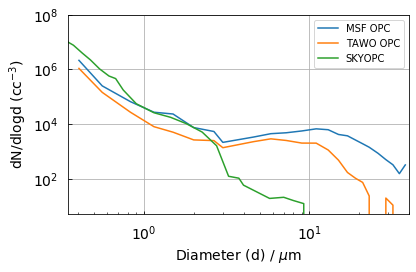

In [123]:

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.grid(True)
ax.loglog(MSF_dist[0],MSF_dist[1],label='MSF OPC')
ax.loglog(TAWO_dist[0],TAWO_dist[1],label='TAWO OPC')
ax.loglog(SKYOPC_dist[0],SKYOPC_dist[1],label='SKYOPC')

ax.set_xlim(bounds[0],bounds[-1])
ax.set_xlabel('Diameter (d) / $\mu$m')
ax.set_ylabel('dN/dlogd (cc$^{-3}$)')

ax.legend(loc='best',fontsize=10)
fig.tight_layout()
